## Exo 13

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

Voici la définition des fonctions pour l'algorithme des K-Means.

In [3]:
def MoyEstim(wk, X):
    """
    Effectue la moyenne pondérée des éléments de X, colonne par colonne.

    Parameters
    ----------
    wk : numpy.ndarray
        Vecteur de pondérations (1D).
    X : numpy.ndarray
        Tableau à moyenner (2D, 1 échantillon par ligne).

    Returns
    -------
    numpy.ndarray
        Vecteur ligne représentant la moyenne pondérée de chaque colonne.
    """
    # Calcul de la somme des pondérations
    Nk = np.sum(wk)
    if Nk == 0:  # Évite la division par zéro
        return np.zeros(X.shape[1])

    # Calcul de la moyenne pondérée
    # Broadcasting : wk est étendu sur les colonnes de X pour le produit
    m = np.sum(X * wk[:, np.newaxis], axis=0) / Nk

    return m


def KM(X, M0, precision, maxiter):
    """
        Compute the K-Means algorithm.

        Parameters
        ----------
        X : tableau des données à analyser (1échantillon/ligne)
        M0 : tableau des centres initiaux (1centre/ligne)
        precision : seuil sur l'évolution du critère pour test d'arrêt
        maxiter : seuil sur le nombre d'itérations pour arrêt

        Returns
        -------
        `[numpy.ndarray, int]` : [tableau des centres estimés, nombre d'itérations]
    """

    C = M0.shape[0] # Nombre de classes.
    D = M0.shape[1] # Nombre de dimensions
    N = X.shape[0] # Nombre de points
    

    # Initialisation ---
    E = 1e12
    M = M0
    evol = np.inf
    t = 0
    c = np.zeros(shape=(N, C))
    wk = np.zeros(shape=(N, C))
    M = M0.copy()
    # ------------------

    # Boucle principale-
    while (t < maxiter) and (evol > precision):
        # Calcul des distance L2 entre chaque échantillon et centre de classe
        for j in range(C):
            c[:, j] = cdist(X, M[j, :].reshape((1, D))).flatten()
        # Calcul des variables d'affectation aux classes
        for j in range(C):
            wk[:, j] = c[:, j] == np.min(c, axis=1) # One-hot encoding
        # Estimation des moyennes 
        for j in range(C):
            M[j , :] = MoyEstim(wk[:, j], X)
        
        # Test d'arrêt 
        Ep = E
        E = np.sum(np.sum(c ** 2 * wk, axis=1)) # anciennement : np.sum(np.sum(c ** 2 * wk, axis=1))
        evol = np.abs(Ep - E) / Ep
        t = t + 1

    return M, t


def PatternMatching(X, M):
    """
        Classification vectorielle selon la moyenne la plus proche.

        Parameters
        ----------
        X : tableau des données à analyser (1échantillon/ligne)
        M0 : tableau des centres des classes (1centre/ligne)

        Returns
        -------
        `numpy.ndarray` : tableau des labels attribués (vec.colonne)
    """
    C = M.shape[0] # Nombre de classes
    N = X.shape[0] # Nombre de points
    D = X.shape[1] # Nombre de dimensions
    c = np.zeros(shape=(N, C))
    labels = np.ones(N)

    # Calcul des distances L2 entre chaque échantillon et centre de classe
    for i in range(C):
        c[:, i] = cdist(X, M[i, :].reshape((1, D))).flatten()

    # Classif
    labels = np.argmin(c, axis=1)
    return labels

Sur un exemple simple (deux lois gaussiennes en dimension 2).

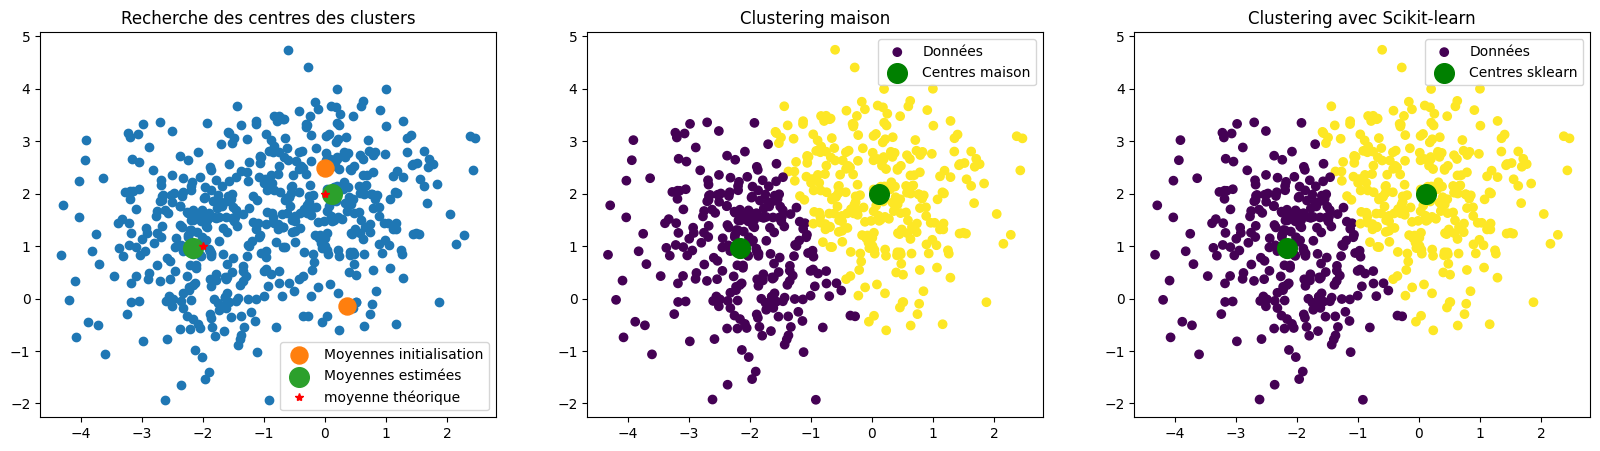

In [4]:
# Exemple simple en dim 2
X1 = np.random.multivariate_normal([-2, 1], np.eye(2), size=250)
X2 = np.random.multivariate_normal([0, 2], np.eye(2), size=300)
X = np.concatenate((X1,X2), axis=0)


# K-Means "maison" ---------
M0 = np.random.multivariate_normal([0, 0], np.eye(2), size=2)  # Initialisation random des centres
M, iter = KM(X, M0, precision=1e-12, maxiter=10000)
labels = PatternMatching(X, M)

# K-Means avec Scikit-learn ---
kmeans = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, random_state=42)
kmeans.fit(X)
centres_sklearn = kmeans.cluster_centers_
labels = kmeans.labels_

fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].scatter(X[:,0], X[:,1])
axs[0].scatter(M0[:, 0], M0[:, 1], s=150, label='Moyennes initialisation')
axs[0].scatter(M[:, 0], M[:, 1], s=200, label='Moyennes estimées')
axs[0].plot([-2, 0], [1, 2], '*r', label='moyenne théorique')
axs[0].legend()
axs[0].set_title('Recherche des centres des clusters')
axs[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', label="Données")
axs[1].scatter(M[:, 0], M[:, 1], color='green', s=200, label="Centres maison")
axs[1].set_title("Clustering maison")
axs[1].legend()
axs[2].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', label="Données")
axs[2].scatter(centres_sklearn[:, 0], centres_sklearn[:, 1], color='green', s=200, label="Centres sklearn")
axs[2].set_title("Clustering avec Scikit-learn")
axs[2].legend()


# Avec une image.

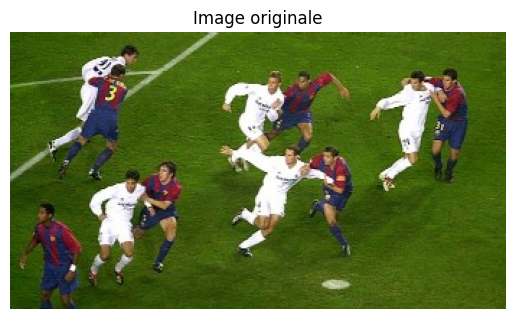

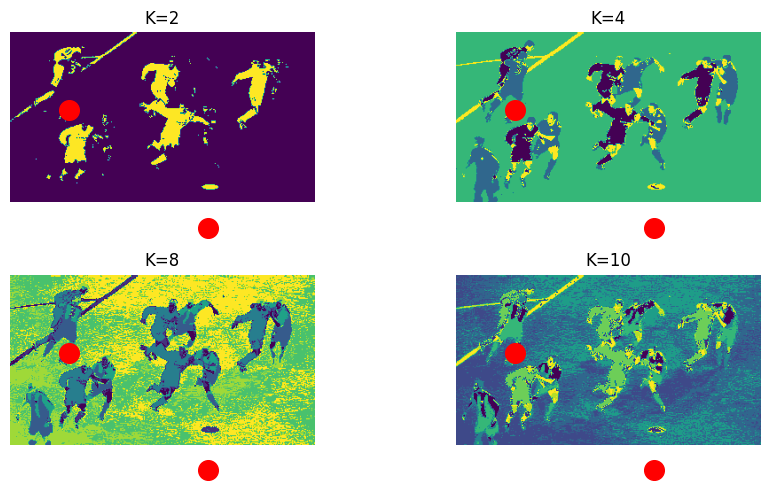

In [84]:
# Chargement de l'image
I = Image.open('Image.jpg')
Ia = np.array(I)

# Conversion de l'image en un tableau 2D
Ia_2d = Ia.reshape((Ia.shape[0] * Ia.shape[1], Ia.shape[2]))

# Paramètres des clusters à tester
clusters = [2, 4, 8, 10]

# Affichage de l'image originale
plt.imshow(Ia), plt.title('Image originale'), plt.axis('off')

# Création des subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

# Clustering et affichage des résultats pour chaque valeur de clusters
for i, k in enumerate(clusters):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300)
    kmeans.fit(Ia_2d)
    labels = kmeans.labels_
    centres = kmeans.cluster_centers_
    
    # Reshape des labels pour correspondre aux dimensions de l'image
    clustered_image = labels.reshape((Ia.shape[0], Ia.shape[1]))
    
    # Affichage du résultat
    axs[i].imshow(clustered_image)
    axs[i].scatter(centres_sklearn[:, 0], centres_sklearn[:, 1], color='red', s=200, label="Centres sklearn")
    axs[i].set_title(f"K={k}")
    axs[i].axis('off')

# Ajustement de l'espacement
fig.tight_layout()
plt.show()

Cas à deux classes.

In [89]:
h, w, p = Ia.shape
K = 3
X = Ia.reshape((w*h, p))
indx = np.random.choice(w*h, K)
print('Centres initiaux : ', indx)
M0 = X[indx, :]
print("M0 = ", M0)

Centres initiaux :  [44373 46918 53399]
M0 =  [[ 64  93  11]
 [ 60  87  10]
 [230 226 201]]


In [ ]:
def test(K,A):
    h, w, p = A.shape
    X = A.reshape((w*h, p))
    indx = np.random.choice(w*h, K)
    print('Centres initiaux : ', indx)
    M0 = X[indx, :]
    M, niter = KM(X, M0, 1e-5, 100)
    labels = PatternMatching(X, M)
    S = labels.reshape((h, w))
    print("M.shape = ", M.shape)
    U = M[labels,:] # <<<<<<<<<<<<<----------------------- PYTHON = STYL
    V = U.reshape((h, w, p))

    fig, axs = plt.subplots(1, 3, figsize=(15,10))
    axs[0].imshow(A), axs[0].set_title('Image originale'), axs[0].axis('off')
    axs[1].imshow(S), axs[1].set_title('Image quantifiée (K = {:d})'.format(K)), axs[1].axis('off')
    axs[2].imshow(V), axs[2].set_title('Image déquantifiée'), axs[2].axis('off')
    plt.show()

Centres initiaux :  [31788 65550]
M.shape =  (2, 3)


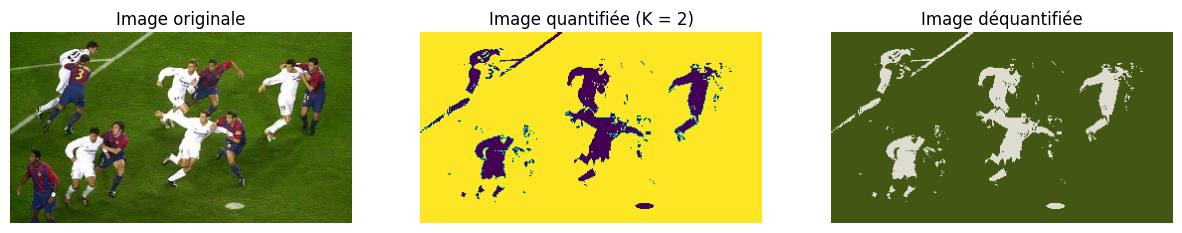

Centres initiaux :  [ 6287   607 42436 27902]
M.shape =  (4, 3)


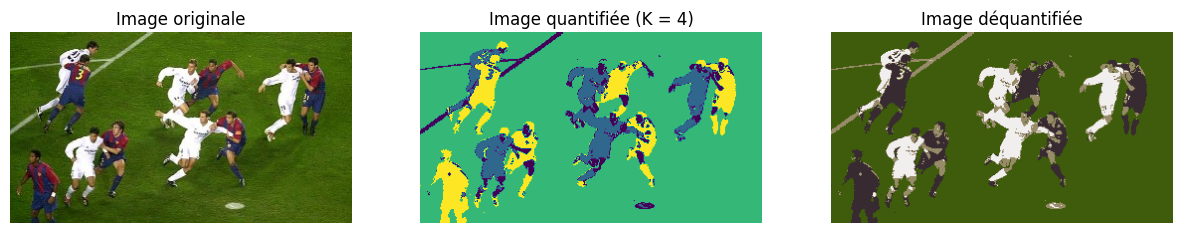

Centres initiaux :  [60615 42248 27535 11992 15893 60013 60684 57195]
M.shape =  (8, 3)


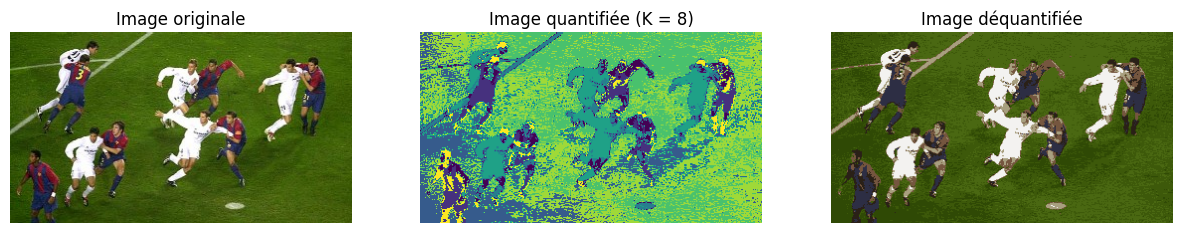

Centres initiaux :  [49145 35665  4841 34045 50190 59347  1231 54984 52187 18867]
M.shape =  (10, 3)


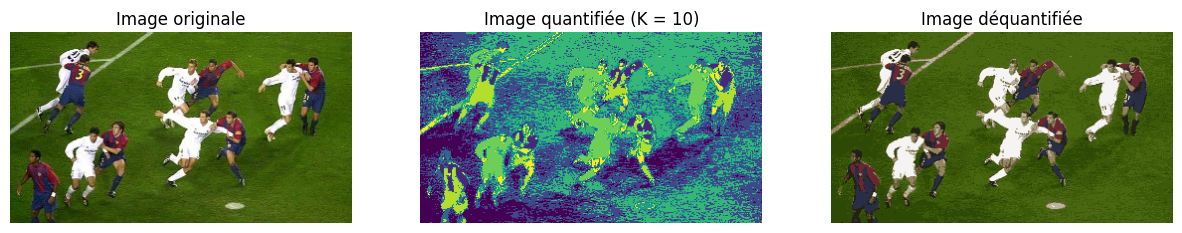

In [104]:
test(K = 2, A = Ia)
test(K = 4, A = Ia)
test(K = 8, A = Ia)
test(K = 10, A = Ia)